In [35]:
# Provided in the starter code
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
# Provided in the starter code
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
# Provided in the starter code, I added distinct  
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [38]:
# Provided in the starter code
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# Reflect an existing database into a new model. I used the automap_base() 
# to generate an ORM. 
Base = automap_base()

# Reflect the tables. The following line will allow an iteraction with the database. 
Base.prepare(autoload_with=engine)

In [40]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table

# Reference to 'station' table:
Station = Base.classes.station

# Reference to 'measurement' table:
Measurement = Base.classes.measurement

In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set. 
# For this task, i used session.query to select the column from the 
# measurement table. I used order_by to sort the dates in descending order.
# I then used the .first() to retrive only the first result - which is 
# the most recent date.  
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

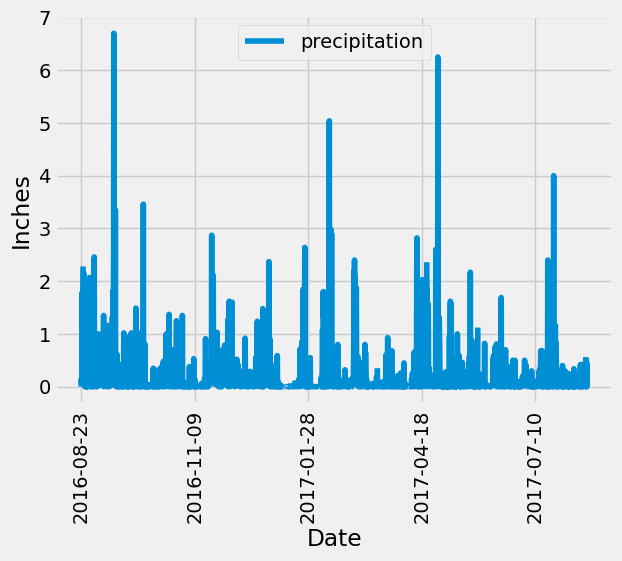

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# I started by creating a subquery to retrieve the latest date. 
latest_date_subquery = session.query(func.max(Measurement.date)).scalar()

# Perform a query to retrieve the data and precipitation scores
# The following code will query the 12 months of precipitation data using the latest date dynamically. 
precip_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= func.date(latest_date_subquery, "-365 day"))
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names. 
df = pd.DataFrame(precip_data, columns=["date", "precipitation"])

# Sort the dataframe by date
df = df.set_index("date")
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# The Pandas DataFrame plot() automatically assigns the date as the X variable since the date 
# is set as the index. Since precipitation is the remaining numerical column, Pandas will 
# automatically use it as the Y value. 
df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data.
# I used the .describe() to calculate the summary of statistics. 
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number of stations in the dataset
# I used the func.count function to count the number of items and used distinct function to 
# ensure that each station is counted only once. The count of unique stations is then stored 
# in the total stations variable. 
total_stations = session.query(func.count(distinct(Measurement.station))).all()
total_stations

[(9,)]

In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# For this task, I grouped the stations, counted the number of stations by way of 
# counting the rows and then sorted the results in descending order. 
# The result is stored in the active_stations variable as a list of tuples with each tuple 
# containing the station and the number of times it appears in the Measurement table. 
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc()).all()
)
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# I used the following code to identify the most active station from the above list. 
most_active_station = active_stations[0][0]

# Then I used the func.min, func.max, and func.avg to calculate the requested values. 
# The results of the calculations stores a list with a single tuple containing the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

temperature_stats


[(54.0, 85.0, 71.66378066378067)]

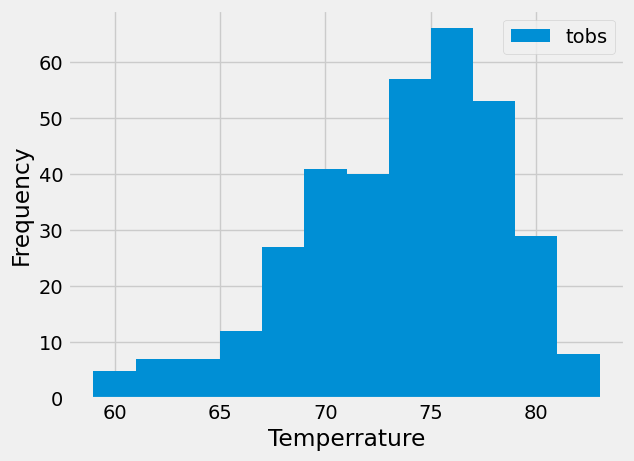

In [48]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Step one would have been to find the most active station, which is already done above. 
# The following codes extracts the actual latest date dynamically. 
latest_date = session.query(func.max(Measurement.date)).scalar()

# The following code converts it into a date object 
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d").date()

# I then calculate one year ago dynamically:
one_year_ago = latest_date - dt.timedelta(days=365)

# Then I queried to get the 12 months of temperature observation data for the most_active_station. 
most_active_station_temp_data = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Converted the ouput of the above query into a dataframe. 
active_station_df = pd.DataFrame(most_active_station_temp_data)

# Plotted the dataframe into a histogram with 12 bins as required. 
active_station_df.plot.hist(bins=12)
plt.xlabel("Temperrature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [49]:
# Close Session
session.close()